In [1]:
# Load python packages
import cv2
import numpy as np
import scipy 
import scipy.linalg 
#import pykitti
import glob
import yaml
import csv

# Inline plotting or interactive? 
# Attention:
# 1. Need restart kernel
# 2. Need to declare before import matplotlib
%matplotlib inline
#%matplotlib notebook

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


#-------------
# Dataset location
#-------------
# Change this to the directory where you store EuRoC MAV data
basedir = '/Users/jinchengli/study/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/'

## Tile-based KLT tracker

<IPython.core.display.Javascript object>


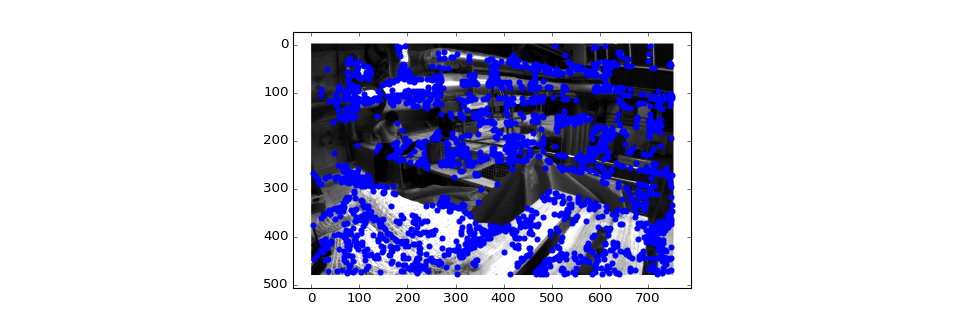

image size (w, h):  752 480
Tile (y,x): 0 0
New corners detected: 35
Total corners (35, 1, 2)
Tile (y,x): 0 100
New corners detected: 50
Total corners (85, 1, 2)
Tile (y,x): 0 200
New corners detected: 50
Total corners (135, 1, 2)
Tile (y,x): 0 300
New corners detected: 50
Total corners (185, 1, 2)
Tile (y,x): 0 400
New corners detected: 50
Total corners (235, 1, 2)
Tile (y,x): 0 500
New corners detected: 50
Total corners (285, 1, 2)
Tile (y,x): 0 600
New corners detected: 45
Total corners (330, 1, 2)
Tile (y,x): 0 700
New corners detected: 9
Total corners (339, 1, 2)
Tile (y,x): 100 0
New corners detected: 46
Total corners (385, 1, 2)
Tile (y,x): 100 100
New corners detected: 50
Total corners (435, 1, 2)
Tile (y,x): 100 200
New corners detected: 50
Total corners (485, 1, 2)
Tile (y,x): 100 300
New corners detected: 50
Total corners (535, 1, 2)
Tile (y,x): 100 400
New corners detected: 50
Total corners (585, 1, 2)
Tile (y,x): 100 500
New corners detected: 50
Total corners (635, 1, 2)
T

<IPython.core.display.Javascript object>


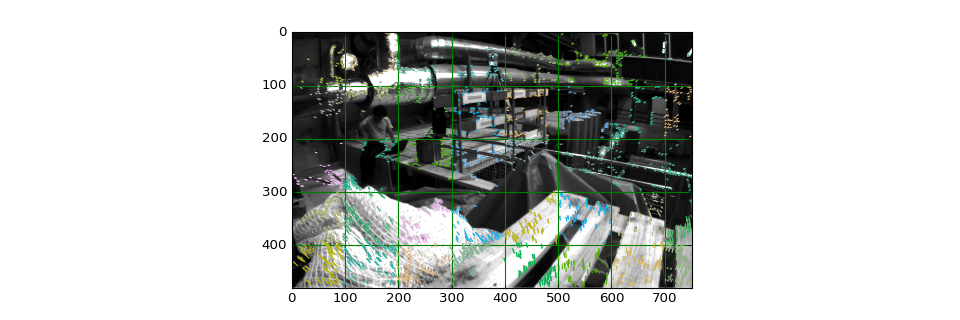

Frame  1 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1910, 4)
feature_list.shape:  (1910, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [14 68 34 13 42  1 69  5 29 50  0 33 53 48 22 57 16 28  4 45  6  8 38 65 23
 56 35 61  3 63 60 46 17 15 59 36 40 37 54 21 11 26 41 52 62 10 31 44 19 32
 27 25 51 12 64 55 18 30 66 24 43 58 47  2  9 20 49  7 39 67]
[[ 1.00090492]
 [ 0.99514604]
 [-2.19854259]
 [-0.37769759]] min_err =  0.0128143 inliers =  70   100.0 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [56 42  2 51 38 92  0 24 35 18 45  1 78 44 68 84 17 34 61 70 59 88  8 65 10
 47 89 80 96 63  6 41 77 54 93 39 67 46 82 99  9 83 71 32 94 73 85 69 48 29
 52 13 74 15 76 66 14  5 12 55  4 21 95 49 40 31 2

<IPython.core.display.Javascript object>


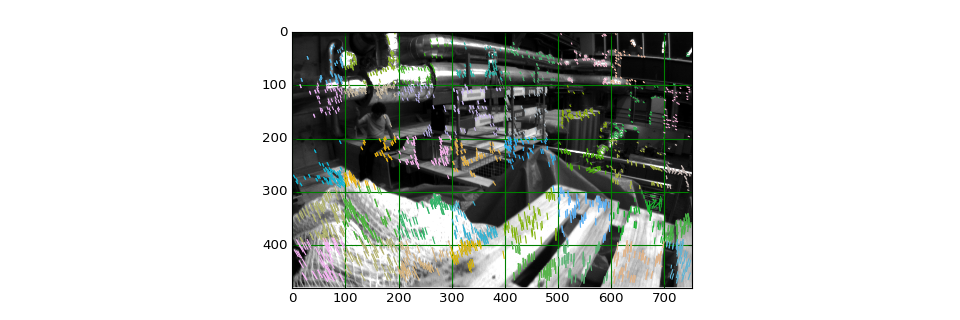

Frame  2 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1906, 4)
feature_list.shape:  (1906, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [58 43 24 68 14 34 12  8 18 35 67  3 62 37 11 66 54 20 16 44 42  6 22 55 38
 28 32 60 56 41 50 23 46 40 45 49 59  4 33 65 17 53 30 36 29 48  7 61  0 52
 69 63 21 10 57 26  2  1 64 31 51 39]
[[ 1.00207293]
 [ 0.98750317]
 [-1.74684072]
 [-3.60763335]] min_err =  0.0109832 inliers =  62   88.57142857142857 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [ 3 46 64 70 26 68 10 30 58 82 78  6 40 20 44 56 29  2 33 11 53 13 34 42 14
 94 51 23 93 65 18 74 96 48 76 72 90 25 15 75 69  1 47 21 62 36 55 27  5 12
 87  8 88 59 49 89  9 86 67  0 80 38 98  7 24 91 79 52 19 35 8

In [2]:
# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
## Interactive mode - show image of every frame interactively.
INTERACTIVE = True


# Tile size
tile_size = 100

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 3, 1)

#-------------
# Main(): Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    plt.imshow(cam0,cmap='gray')

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []

    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

#        # Draw filtered feature points and associated OF
#        for idx in range(feature_list.shape[0]):
#            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
#                            [feature_list[idx,1], feature_list[idx,3]],
#                            linestyle='-', color='plum')

#        # Draw old feature points
#        #plt.scatter(good_old[:,0], good_old[:,1], marker='^', c='g')
#        # Draw new feature points
#        #plt.scatter(good_new[:,0], good_new[:,1], marker='o', c='r')
#        # Draw optical flow
#        for idx in range(good_old.shape[0]):
#            plt.plot([good_old[idx,0], good_new[idx,0]], 
#                            [good_old[idx,1], good_new[idx,1]],
#                            linestyle='-', color='b')

        # Find affine parameters sx,sy,tx,ty for each grid
        of.OF_TileAffineSolver(cam0, tile_size, feature_list)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)



    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'_of.png')
    # Show the OF tracking image
    if INTERACTIVE:
        plt.show()
    
        ## Use opencv to show image
        #cv2.imshow('cam0',cam0)
        #k = cv2.waitKey(-1)
        #cv2.destroyAllWindows()

## Frame-level KLT tracker

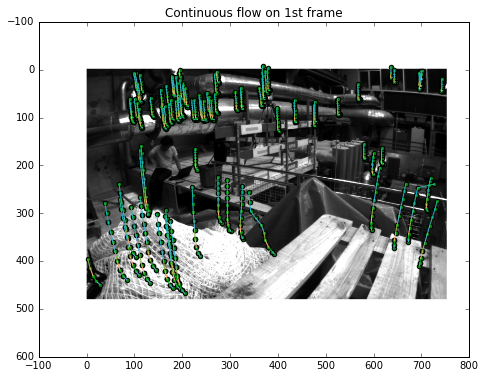

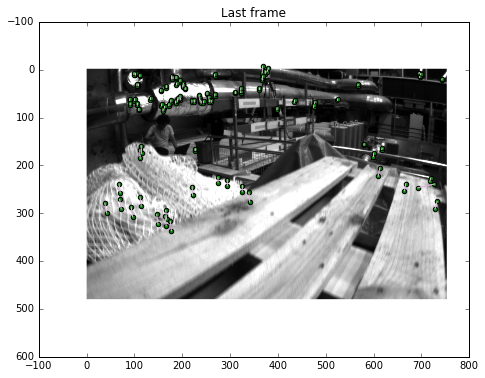

In [9]:
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 10, 1)

#-------------
# Processing cam
#-------------
dpi = 80

# Read 1st frame
cam0 = cv2.imread(cam0_img_list[0], cv2.IMREAD_GRAYSCALE)

# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
#plt.autoscale(tight=True)


# Show the gray img from camera 0
plt.imshow(cam0, cmap='gray')
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        #plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
plt.show()

# Draw last frame
plt.figure(figsize=figsize)
#plt.axis('off')
plt.imshow(cam0, cmap='gray')
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()
    

## Camera distortion correction

Use page: https://hackaday.io/project/12384-autofan-automated-control-of-air-flow/log/41862-correcting-for-lens-distortions

cam0 intrinsics = 
 [[ 458.654    0.     367.215]
 [   0.     457.296  248.375]
 [   0.       0.       1.   ]]
cam0 distortion_coeffs = 
 [ -2.83408110e-01   7.39590700e-02   1.93590000e-04   1.76187114e-05
   0.00000000e+00]
cam0 T_BS (MAV body to camera sensor) = 
 [[ 0.01486554 -0.99988093  0.0041403  -0.02164015]
 [ 0.99955725  0.01496721  0.02571553 -0.06467699]
 [-0.02577444  0.00375619  0.99966073  0.00981073]
 [ 0.          0.          0.          1.        ]]


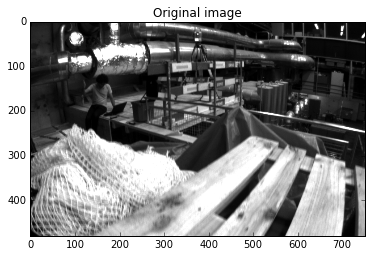

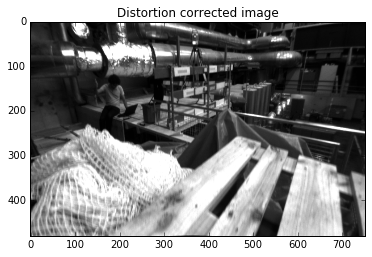

(480, 752) (480, 752) (480, 752)


In [4]:
import yaml

# Load cam0 sensor config
with open(basedir+'mav0/cam0/sensor.yaml') as fp:
    cam0_yaml = yaml.load(fp)
#print(cam0_yaml)
fp.close()

# K - intrinsics
K_params = cam0_yaml['intrinsics']
K = np.array([
    [K_params[0], 0., K_params[2]],
    [0., K_params[1], K_params[3]],
    [0., 0., 1.]
]) 
print("cam0 intrinsics = \n", K)

# D - distortion coefficients
D_params = cam0_yaml['distortion_coefficients']
D = np.hstack([D_params[:], 0.])
print("cam0 distortion_coeffs = \n", D)

w, h = cam0_yaml['resolution']

# T_BS - [R t] from MAV body coordinates to sensor (cam0) coordinates
T_BS = cam0_yaml['T_BS']['data']
T_BS_cols = cam0_yaml['T_BS']['cols']
T_BS_rows = cam0_yaml['T_BS']['rows']
T_BS = np.array(T_BS).reshape(T_BS_rows, T_BS_cols)
print("cam0 T_BS (MAV body to camera sensor) = \n", T_BS)

# Generate new camera matrix from parameters
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 0)

# Generate look-up tables for remapping the camera image
mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, newcameramatrix, (w, h), 5)

# Remap the original image to a new image
#new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR)
new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Display old and new image

plt.imshow(cam0, cmap='gray')
plt.title('Original image')
plt.show()
plt.imshow(new_cam0, cmap='gray')
plt.title('Distortion corrected image')
plt.show()

print(mapx.shape, mapy.shape,cam0.shape)

## Frame-level KLT tracker on undistorted image

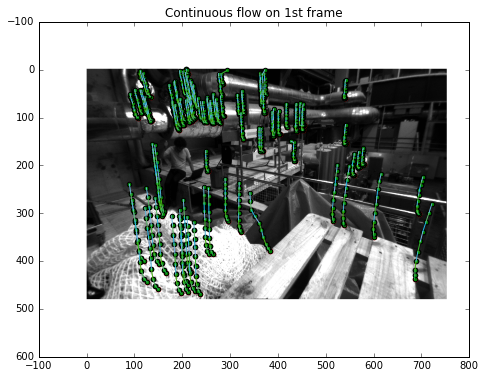

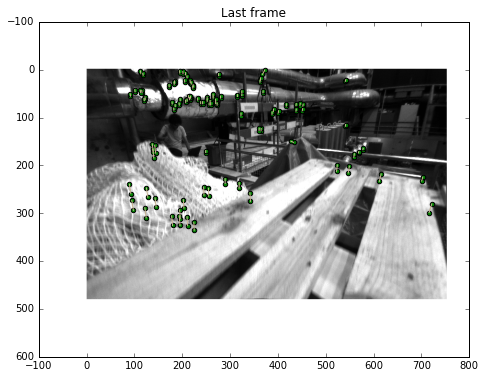

In [5]:
#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 10, 1)

#-------------
# Processing cam
#-------------
dpi = 80

# Read 1st frame
cam0_ori = cv2.imread(cam0_img_list[0], cv2.IMREAD_GRAYSCALE)
# Image undistortion
cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
#plt.autoscale(tight=True)


# Show the gray img from camera 0
plt.imshow(cam0, cmap='gray')
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0_ori = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    # Image undistortion
    cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
plt.show()

# Draw last frame
plt.figure(figsize=figsize)
plt.imshow(cam0, cmap='gray')
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()

## Trajectory drawing

Useful page: https://matplotlib.org/examples/mplot3d/lines3d_demo.html


### Load trajectory from dataset

In [5]:

def q2R(w, x, y, z):
    """
    Transform a unit quaternion into its corresponding rotation matrix (to
    be applied on the right side).
      
    :returns: transform matrix
    :rtype: numpy array
  
    """
    xx2 = 2 * x * x
    yy2 = 2 * y * y
    zz2 = 2 * z * z
    xy2 = 2 * x * y
    wz2 = 2 * w * z
    zx2 = 2 * z * x
    wy2 = 2 * w * y
    yz2 = 2 * y * z
    wx2 = 2 * w * x
      
    R = np.empty((3, 3), float)
    R[0,0] = 1. - yy2 - zz2
    R[0,1] = xy2 - wz2
    R[0,2] = zx2 + wy2
    R[1,0] = xy2 + wz2
    R[1,1] = 1. - xx2 - zz2
    R[1,2] = yz2 - wx2
    R[2,0] = zx2 - wy2
    R[2,1] = yz2 + wx2
    R[2,2] = 1. - xx2 - yy2
      
    return R
    
# Load leica0 sensor config - position measurement mounted on IMU (ADIS16448)
with open(basedir+'mav0/leica0/sensor.yaml') as fp:
    leica0_yaml = yaml.load(fp)
fp.close()
# T_BL - [R t] from MAV body coordinates to sensor (leica0) coordinates
#   As it is rigidly mounted on IMU, there's only translation from B.
T_BL = leica0_yaml['T_BS']['data']
T_BL_cols = leica0_yaml['T_BS']['cols']
T_BL_rows = leica0_yaml['T_BS']['rows']
T_BL = np.array(T_BL,dtype='float').reshape(T_BL_rows, T_BL_cols)
print("leica0 T_BL (MAV body to leica0 prism marker) = \n", T_BL)

# Trajectory points
T_WL_x = []
T_WL_y = []
T_WL_z = []

# Load ground truth data of leica0 prism marker
CSV_READ_N_LINES = 36000
with open(basedir+'mav0/state_groundtruth_estimate0/data.csv', newline='') as fp:
    reader = csv.reader(fp)
    # Skip first line, specifying column contents category
    next(reader)
    for i,row in enumerate(reader):
        tx, ty, tz, qw, qx, qy, qz = np.array(row[1:8]).astype('float')
        #print(tx, ty, tz, qw, qx, qy, qz)
        R = q2R(qw, qx, qy, qz)
        t = np.array([tx,ty,tz]).reshape(3,1)
        T_WL = np.hstack([R, t])
        #print("T_WL (world to leica0) = \n", T_WL)
        
        T_WL_x.append(tx)
        T_WL_y.append(ty)
        T_WL_z.append(tz)
        
        if i > CSV_READ_N_LINES:
            break
        
fp.close


leica0 T_BL (MAV body to leica0 prism marker) = 
 [[ 1.         0.         0.         0.0748903]
 [ 0.         1.         0.        -0.0184772]
 [ 0.         0.         1.        -0.120209 ]
 [ 0.         0.         0.         1.       ]]


<function TextIOWrapper.close>

### Draw the trajectory

<IPython.core.display.Javascript object>


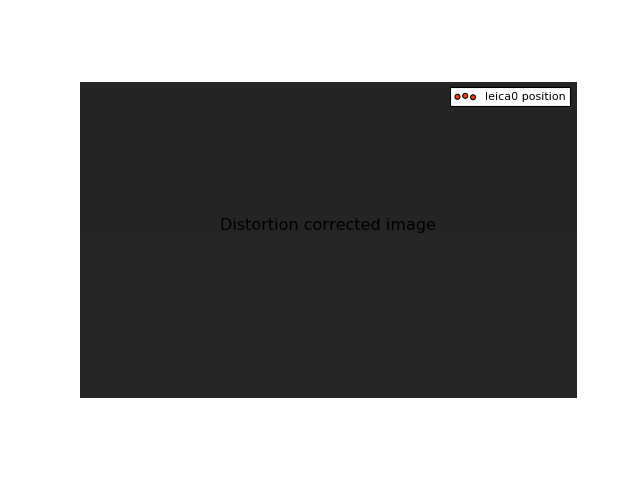

In [6]:

# Draw the trajectory 
matplotlib.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(T_WL_x, T_WL_y, T_WL_z, c=T_WL_z, label='leica0 position')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Top-down view?
ax.view_init(azim=270, elev=90)

plt.show()
